Sarsa(λ)
---
Very few changes in the ideas already presented in this chapter are required in order to extend eligibility-traces to action-value methods.

<img src="Sarsa(lambda).png" width="700">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from TileCoding import *
from mpl_toolkits.mplot3d import Axes3D

In [2]:
VELOCITY_BOUND = [-0.07, 0.07]
POSITION_BOUND = [-1.2, 0.5]
ACTIONS = [-1, 0, 1]

In [7]:
class ValueFunction:
    
    def __init__(self, stepSize=0.3, numOfTilings=8, maxSize=2048, lam=0.9, gamma=1, method="replacing"):
        self.method = method
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling
        self.stepSize = stepSize / numOfTilings  # learning rate for each tile

        self.hashTable = IHT(maxSize)

        # weight for each tile
        self.weights = np.zeros(maxSize)
        
        # trace vector
        self.z = np.zeros(maxSize)
        
        self.lam = lam
        self.gamma = gamma

        # position and velocity needs scaling to satisfy the tile software
        self.positionScale = self.numOfTilings / (POSITION_BOUND[1] - POSITION_BOUND[0])
        self.velocityScale = self.numOfTilings / (VELOCITY_BOUND[1] - VELOCITY_BOUND[0])

    # get indices of active tiles for given state and action
    def getActiveTiles(self, position, velocity, action):
        # I think positionScale * (position - position_min) would be a good normalization.
        # However positionScale * position_min is a constant, so it's ok to ignore it.
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.positionScale * position, self.velocityScale * velocity],
                            [action])
        return activeTiles

    # estimate the value of given state and action
    def value(self, position, velocity, action):
        if position == POSITION_BOUND[1]:
            return 0.0
        activeTiles = self.getActiveTiles(position, velocity, action)
        return np.sum(self.weights[activeTiles])

    # learn with given state, action and target
    def update(self, position, velocity, action, target):
        activeTiles = self.getActiveTiles(position, velocity, action)
        
        # update traces
        if self.method = "accumulating":
            self.z *= self.gamma*self.lam
            self.z[activeTiles] += 1
        
        if self.method = "replacing":
            active = np.isin(range(len(self.z)), activeTiles)
            self.z[active] = 1
            trace[~active] *= lam * DISCOUNT
            self.z[activeTiles] = 1
        # update weights
        estimation = np.sum(self.weights[activeTiles])
        delta = self.stepSize * (target - estimation)
        self.weights += self.stepSize*delta*self.z
        
    # get the # of steps to reach the goal under current state value function
    def costToGo(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)

In [ ]:
np.isin()

In [21]:
class MountainCar:
    
    def __init__(self, exp_rate=0.1, debug=True):
        self.actions = [-1, 0, 1]  # reverse, 0 and forward throttle
        self.state = (-0.5, 0)  # position, velocity
        self.exp_rate = exp_rate
        self.end = False
        self.debug = debug
        
    def reset(self):
        pos = np.random.uniform(-0.6, -0.4)
        self.end = False
        self.state = (pos, 0)
        
    def takeAction(self, action):
        pos, vel = self.state
        
        vel_new = vel + 0.001*action - 0.0025*np.cos(3*pos)
        vel_new = min(max(vel_new, VELOCITY_BOUND[0]), VELOCITY_BOUND[1])
        
        pos_new = pos + vel_new
        pos_new = min(max(pos_new, POSITION_BOUND[0]), POSITION_BOUND[1])
        
        if pos_new == POSITION_BOUND[0]:
            # reach leftmost, set speed to 0
            vel_new = 0
        nxtState = (pos_new, vel_new)
        return nxtState
    
    def chooseAction(self, valueFunc, state):
        # choose an action based on given state
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                pos, vel = state
                value = valueFunc.value(pos, vel, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v==max(values.values())])
        
    def giveReward(self, state):
        # give reward based on state
        pos, _ = state
        if pos == POSITION_BOUND[1]:
            self.end = True
            return 0
        return -1
        
    def play(self, valueFunction, rounds=50):
        total_steps = 0
        for rnd in range(1, rounds+1):
            steps = 0
            self.reset()
            while True:
                currentState = self.state
                action = self.chooseAction(valueFunction, currentState)
                nxtState = self.takeAction(action)  # next state
                reward = self.giveReward(nxtState)  # next state-reward
                nxtAction = self.chooseAction(valueFunction, nxtState)
                
                target = reward + valueFunction.value(nxtState[0], nxtState[1], nxtAction)
                valueFunction.update(currentState[0], currentState[1], action, target)
                
                self.state = nxtState 
                steps += 1
                if self.end:
                    total_steps += steps
                    if self.debug: 
                        print("number of steps {}".format(steps))
                    break
    
        return total_steps/rounds

In [27]:
rounds = 50
alphas = np.arange(1, 6) / 4.0
lams = [0.99, 0.95, 0.5, 0]

steps = {}

# for each lambda
for lam in lams:
    steps[lam] = []
    for alpha in alphas:
        print("running alpha {} lambda {}".format(alpha, lam))
        mc = MountainCar(debug=False)
        valueFunc = ValueFunction(stepSize=alpha, lam=lam)
        avg_step = mc.play(valueFunc, rounds=rounds)
        steps[lam].append(avg_step)

running alpha 0.25 lambda 0.99
running alpha 0.5 lambda 0.99
running alpha 0.75 lambda 0.99
running alpha 1.0 lambda 0.99
running alpha 1.25 lambda 0.99
running alpha 0.25 lambda 0.95
running alpha 0.5 lambda 0.95
running alpha 0.75 lambda 0.95
running alpha 1.0 lambda 0.95
running alpha 1.25 lambda 0.95
running alpha 0.25 lambda 0.5
running alpha 0.5 lambda 0.5
running alpha 0.75 lambda 0.5
running alpha 1.0 lambda 0.5
running alpha 1.25 lambda 0.5
running alpha 0.25 lambda 0
running alpha 0.5 lambda 0
running alpha 0.75 lambda 0
running alpha 1.0 lambda 0
running alpha 1.25 lambda 0


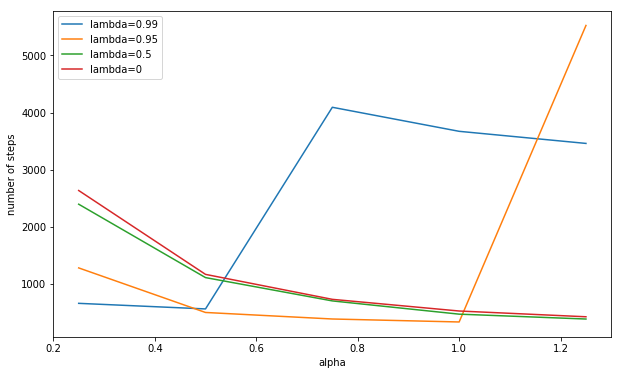

In [28]:
plt.figure(figsize=[10, 6])

for lam in lams:
    plt.plot(alphas, steps[lam], label="lambda={}".format(lam))
    
plt.xlabel("alpha")
plt.ylabel("number of steps")
plt.legend()

In [30]:
np.in1d(range(10), [2, 4, 5])

array([False, False,  True, False,  True,  True, False, False, False,
       False])

In [ ]:
np.in1d(np.arange(len(trace)), activeTiles)